The goal of this project is to build a predictive model that is able to classify the outcome of a match in the English
Premier League with enough accuracy to be able to make a profit in the betting market. In terms of the betting data, there is one dataset per season, each consisting of 380 rows, one for each match, and 68 columns, most of which are the odds for various bets. Of the columns that contain data that are performance metrics we choose 3 to include in our model: goals, shots and corners. We create the features by using a simple moving average to capture the short term form of a team. We do this for both of the teams competing in the match. These averages are then subtracted from each other so we end up with 3 features derived from this data. We also have avaiable to us data scraped from the web containing each team's position after each matchweek. We make use of this data by creating a 4th feature by subtracting the position of the away team from the position of the home team. This feature captures the long term performances of the teams. 

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from ray import tune
import torchvision.transforms as transforms
from functools import partial
import jellyfish

In [3]:
DIR_NAME = os.getcwd()
NUM_CLASSES = 3
NUM_FEATS = 4
NUM_GAMES = 38
YEAR_BEG = 13
YEAR_END = 19
COL_NAMES = ['goal_diff', 'shot_diff', 'corner_diff']
NAME_RES_COLS = ['HomeTeam', 'AwayTeam', 'FTR']
POS_COLS = ['HPOS', 'APOS']
BET_COL_IDX = 23 
MIN_PERIODS= 5

We first gather the betting data into a list of dataframes.

In [4]:
def read_data(beg, end):
    '''
    Stores data for all seasons between beg and end in separate 
    DataFrames.
    
    Parameters:
    beg (int): int of the season to start at (e.g. 12)
    end (int): int of the season to end at
    
    Returns:
    datasets (list): list of DataFrames each containing the data for a 
    particular season
    '''
    years = [str(i) + str(i+1) for i in range(beg,end)]
    datasets = []
    for suffix in years:
        csv = DIR_NAME + '/data/match_stats' + suffix + '.csv' 
        dat = pd.read_csv(csv)
        datasets.append(dat)  
    return datasets

datasets = read_data(YEAR_BEG, YEAR_END)
for data in datasets:
    print(data)


    Div      Date     HomeTeam     AwayTeam  FTHG  FTAG FTR  HTHG  HTAG HTR  \
0    E0  17/08/13      Arsenal  Aston Villa     1     3   A     1     1   D   
1    E0  17/08/13    Liverpool        Stoke     1     0   H     1     0   H   
2    E0  17/08/13      Norwich      Everton     2     2   D     0     0   D   
3    E0  17/08/13   Sunderland       Fulham     0     1   A     0     0   D   
4    E0  17/08/13      Swansea   Man United     1     4   A     0     2   A   
..   ..       ...          ...          ...   ...   ...  ..   ...   ...  ..   
375  E0  11/05/14      Norwich      Arsenal     0     2   A     0     0   D   
376  E0  11/05/14  Southampton   Man United     1     1   D     1     0   H   
377  E0  11/05/14   Sunderland      Swansea     1     3   A     0     2   A   
378  E0  11/05/14    Tottenham  Aston Villa     3     0   H     3     0   H   
379  E0  11/05/14    West Brom        Stoke     1     2   A     0     1   A   

     ... BbAv<2.5  BbAH  BbAHh  BbMxAHH  BbAvAHH  B

We consider the net score as opposed to the raw score for each metric so we do not penalize more defensive minded teams who may have a relatively low raw score but also restrict their opponent's scores. We also print the proportions of each class to get a sense of the difficulty of the problem

In [5]:
for data in datasets:
    data['goal_diff'] = data['FTHG'] - data['FTAG']
    data['shot_diff'] = data['HST'] - data['AST']
    data['corner_diff'] = data['HC'] - data['AC']
    size = data.shape[0]
    
    print(data[data['FTR'] == 'D'].shape[0]/size, data[
          data['FTR'] == 'A'].shape[0]/size,      
          data[data['FTR'] == 'H'].shape[0]/size)

0.20526315789473684 0.3236842105263158 0.4710526315789474
0.24473684210526317 0.3026315789473684 0.45263157894736844
0.28157894736842104 0.30526315789473685 0.4131578947368421
0.22105263157894736 0.2868421052631579 0.4921052631578947
0.26052631578947366 0.28421052631578947 0.45526315789473687
0.1868421052631579 0.3368421052631579 0.4763157894736842


Next, we read the positional data into a list of lists, with the (i,j) <sup> th </sup> entry being the league table during season i after MIN_PERIOD + j games.

In [6]:
def read_pos_data(beg, end):
    '''
    Reads the positional data into a list of lists. The outer level is 
    the season, and the inner level is the round.
    
    Paramaters:
    beg (int): int of the season to start at (e.g. 12)
    end (int): int of the season to end at
    
    Returns:
    dfs (list of list): a list of lists of DataFrames each containing the 
    positional data for a given season and round
    
    '''
    dfs = []
    for yr in [str(i) + '-' + str(i+1) for i in range(2000+beg,2000+end)]:
        season_dfs = []
        for rd in range(MIN_PERIODS, NUM_GAMES):
            fpath = DIR_NAME + '/data/table-{}-{}.csv'.format(yr, rd)
            season_dfs.append(pd.read_csv(fpath, index_col=0, names=[
                'Team', 'Match'], header=0))
        dfs.append(season_dfs)
    return dfs

pos_dfs = read_pos_data(YEAR_BEG, YEAR_END)
            

We must resolve the inconsistencies in the names of teams between the two data sources. Rather than hard code the correct mapping for each season, we use the jaro winkler similarity score to automate the process and check for any errors. In the end, only Man City was incorrectly classified so we correct it by hand.  

In [7]:
def get_mapping(arr1, arr2):
    '''
    Establishes a correspondence between two arrays of strings based 
    on the jaro winkler similarity score. Each string in the first array is 
    matched to the string in the second array with the highest similarity score.
    
    Parameters:
    arr1 (iterable): an array of strings
    arr2 (iterable): an array of strings
    
    Returns:
    mapping (dic): map that associates a string in one array with the most 
    similar string in the other array
    
    note: the map is not necessarily 1-1 or surjective
    '''
    mapping = {}
    for name1 in arr1:
        max_score = np.NINF
        closest = ''
        for name2 in arr2:
            score = jellyfish.jaro_winkler_similarity(name1, name2)
            if score > max_score:
                closest = name2
                max_score = score
        mapping[name1] = closest
    
    return mapping

maps = [get_mapping(pd.unique(data['HomeTeam']), 
                    pd.unique(pos_dfs[i][0]['Team'])
                   ) for i, data in enumerate(datasets)]
for i in range(len(maps)):
    maps[i]['Man City'] = 'Manchester City'
    print(maps[i])
datasets = [data.replace(maps[i]) for i, data in enumerate(datasets)]


{'Arsenal': 'Arsenal FC', 'Liverpool': 'Liverpool FC', 'Norwich': 'Norwich City', 'Sunderland': 'Sunderland AFC', 'Swansea': 'Swansea City', 'West Brom': 'West Bromwich Albion', 'West Ham': 'West Ham United', 'Chelsea': 'Chelsea FC', 'Crystal Palace': 'Crystal Palace', 'Man City': 'Manchester City', 'Aston Villa': 'Aston Villa', 'Everton': 'Everton FC', 'Fulham': 'Fulham FC', 'Hull': 'Hull City', 'Newcastle': 'Newcastle United', 'Southampton': 'Southampton FC', 'Stoke': 'Stoke City', 'Cardiff': 'Cardiff City', 'Tottenham': 'Tottenham Hotspur', 'Man United': 'Manchester United'}
{'Arsenal': 'Arsenal FC', 'Leicester': 'Leicester City', 'Man United': 'Manchester United', 'QPR': 'Queens Park Rangers', 'Stoke': 'Stoke City', 'West Brom': 'West Bromwich Albion', 'West Ham': 'West Ham United', 'Liverpool': 'Liverpool FC', 'Newcastle': 'Newcastle United', 'Burnley': 'Burnley FC', 'Aston Villa': 'Aston Villa', 'Chelsea': 'Chelsea FC', 'Crystal Palace': 'Crystal Palace', 'Everton': 'Everton FC',

In order to match the datasets together we need to know which round it is for each match in the betting dataset.

In [8]:
def get_pos_index(row, dic):
    '''
    Gets the round of a given match. We subtract MIN_PERIODS so that 
    the index of the round starts at MIN_PERIODS
    
    Parameters:
    row (indexable): row containing the home team and away team.
    dic: dictionary mapping the team to the current number of rounds it has played
    
    Returns: tuple containing the number of rounds played by the home and away 
    teams, respectively
    '''
    dic[row[0]] += 1
    dic[row[1]] += 1
    return dic[row[0]] - MIN_PERIODS - 1, dic[row[1]] - MIN_PERIODS - 1

def create_pos_index_cols(df):
    '''
    Creates dataframe containing two columns: the number of games played by the 
    home team and the games played by the away team, not including the current 
    match. As usual, the index is the match number.
    
    Parameters:
    df: dataframe containing the names of the home and away teams
    Returns: 
    df: dataframe containing the number of games played by the home and away teams
    '''
    dic = {}
    for name in pd.unique(df['HomeTeam']):
            dic[name] = 0
    games_df = df[['HomeTeam', 'AwayTeam']].apply(
        get_pos_index, axis=1, args=(dic,), result_type='expand').rename(
        {0:'HINDEX', 1:'AINDEX'},axis=1)
    df = df.join(games_df)
    return df

datasets = [create_pos_index_cols(data) for data in datasets]


Now that we have the round numbers for every match, we know which dataframe to look up in order to get both teams' positions at the start of the match.

In [9]:
def get_pos(row, pos_dfs_lst):
    '''
    Gets the position of both teams prior to the start of the match.
    Parameters:
    row (indexable): row containing the Home Team, Away Team, matches 
    played by the home team, matches played by the away team
    pos_dfs_lst (list): a list of lists of DataFrames each containing the 
    positional data for a given season and round 
    '''
    hpos = pos_dfs_lst[row[2]].loc[pos_dfs_lst[row[2]]['Team']==row[0]].index.values[0]
    apos = pos_dfs_lst[row[3]].loc[pos_dfs_lst[row[3]]['Team']==row[1]].index.values[0]
    return hpos, apos

def create_pos_cols(df, pos_df):
    '''
    Creates DataFrame containing the postional information of both team prior to
    the start of the match
    Parameters:
    df: dataframe containing the match data
    pos_df: dataframe containing the positional data
    Returns: DataFrame containing the postional information of both team prior to 
    the start of the match
    '''
    pos_cols_df = df.loc[MIN_PERIODS*10:,(
        'HomeTeam', 'AwayTeam', 'HINDEX','AINDEX')].apply(
        get_pos, args=(pos_df,), axis=1, result_type='expand'
                               ).rename({0:'HPOS', 1:'APOS'},axis=1)
    df = df.join(pos_cols_df)
    
    return df

datasets = [create_pos_cols(data, pos_dfs[i]) for i, data in enumerate(datasets)]    

We then collect the relevant performance metrics (goal, shot and corner differences) for a single team into one data frame. We also note whether that team was the away team for that game.

In [10]:
def get_team_df(df, name, col_names=COL_NAMES):
    '''
    Gets the columns in COL_NAMES for a given team. Also notes whether or not 
    that team was the away team for that game.
    
    Paramaters:
    df (DataFrame): the data for a given season
    name (str): the name of the team
    
    Returns:
    df (DataFrame): DataFrame where each row is a match played by a 
    given team and the columns are those in COL_NAMES and a boolean column 
    indicating whether or not the team was the away team.
    
    '''
    home_df = df.loc[df['HomeTeam']==name][col_names].assign(is_away=False)
    away_df = (-1*df.loc[df['AwayTeam']==name][col_names]).assign(is_away=True)
    df = pd.concat((home_df, away_df)).sort_index()
    
    return df

We get a summary of a team's short term form by taking a simple average of these differences over the past MIN_PERIOD games. We use this summary to create the feature matrix by first collecting all the averages for a given team during a given season. Once we've gathered all the averages for a single season into one DataFrame we combined the averages with the same index by subtracting the away team's average from the home team's average. We also append a column cotaining the difference between the home and away teams' postions, so we end up with 4 features in total

In [11]:
def create_feats_and_targets(datasets):
    '''
    Creates features consisting of the estimate of the home team's short term 
    performance in 3 metrics (goals, shots,corners) subtracted by the estimate 
    of the away team's short term performance in those metrics. Also contains a 
    column consisting of the difference in the Home and Away team's position in 
    the league table, prior to the startof the match. Also creates the a vector 
    of targets which are the outcomes of each match and a list of indices into the 
    seasonal dataframes, which are used to match the odds for a match with the 
    probabilities outputted by our model.
    
    Parameters:
    datasets (list): list of DataFrames, one for each season
    Returns:
    feat_mat (DataFrame): feature matrix as described above
    y (Series): series of outcomes for each match 
    indices (list): list of indices into the seasonal dataframes
    '''
    feat_mat = pd.DataFrame()
    y = pd.Series(dtype='int64')
    indices = []
    for data in datasets:
        ma_df = pd.DataFrame(columns = COL_NAMES)
        for name in pd.unique(data['HomeTeam']):
            df = get_team_df(data, name)
            df = df[COL_NAMES].rolling(
                window=MIN_PERIODS).mean().shift().dropna().assign(
                is_away=df['is_away'])
            df = df.mask(df['is_away'], -df)[COL_NAMES]
            ma_df = pd.concat((ma_df, df)).sort_index()
        index = ma_df.index.unique()
        y = pd.concat((y, data['FTR'].loc[index]))
        feats = ma_df.groupby(ma_df.index).sum()
        feats['pos_diff'] = data.loc[index]['HPOS'] - data.loc[index]['APOS']
        feat_mat = pd.concat((feat_mat, feats))
        indices.append(index)
        print(ma_df.groupby(ma_df.index).sum().shape)
    feat_mat.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    label_encoder = preprocessing.LabelEncoder()
    y = pd.Series(label_encoder.fit_transform(y))
    print(y.shape)
    return feat_mat, y, indices

feat_mat, y, indices = create_feats_and_targets(datasets)
feat_mat
    

(330, 3)
(330, 3)
(330, 3)
(330, 3)
(330, 3)
(330, 3)
(1980,)


,goal_diff,shot_diff,corner_diff,pos_diff
0,-1.6,-3.4,-3.2,10.0
1,-0.4,-0.2,-2.6,2.0
2,-0.4,0.8,0.0,-4.0
3,0.2,1.6,5.0,-6.0
4,1.0,3.2,6.8,-12.0
...,...,...,...,...
1975,2.0,1.0,-2.8,-5.0
1976,-0.2,-0.8,0.0,-12.0
1977,2.0,4.0,3.4,-4.0
1978,-0.6,-2.2,-4.6,-4.0


In partitioning the data, we set aside the most recent season to use as the test set and split the data from the remaining 
seasons into the training and validition sets, with an 80-20 split.

In [12]:
test_start_idx = (NUM_GAMES - MIN_PERIODS)*10*(len(datasets)-1) 
X_tr, X_val, y_tr, y_val = train_test_split(
    feat_mat.iloc[:test_start_idx,:], y[:test_start_idx],
                                            test_size=.2, random_state=42)
X_tst = feat_mat.iloc[test_start_idx:,:]
y_tst = y[test_start_idx:]
y_tst.shape


(330,)

We don't use sklearn's GridSearchCV to tune the hyperparameters of our model as that would prevent us from setting parameters in XGBClassifier's fit method, though this doesn't appear to be the case anymore as of Xgboost v 1.6.0.

In [13]:
def tune_hyperparams(mod, Xtr, ytr, Xval, yval, param_grid, fit_param_dic):
    '''
    Fits model for each element in the cartesian product of the lists 
    of possible values of each parameter given by the param_grid. Then selects 
    the best model based on the validation accuracy.
    
    Parameters:
    mod (sklearn obj): A multiclass classifier
    Xtr (np.array): training data
    ytr (np.array): 1D array of training labels
    Xval (np.array): validation data
    yval (np.array): 1D array of validation labels
    param_grid (dic): maps each parameter to a list of values to be tested
    fit_param_dic (dic): used to implement early stopping for xgboost. Is an 
    empty dictionary for all other classifiers
    Returns:
    validation_scores (dic): maps a given combination of parameters to the 
    validation score for that model
    best_params_dic (dic): maps the parameter to its optimals value
    
    
    '''
    validation_scores = {}
    keys, vals = zip(*sorted(param_grid.items()))
    for it, params in enumerate(itertools.product(*vals)):
        #print(dict(zip(keys, params)))
        if it % 50 == 0:
            print(it, params)
        mod.set_params(**dict(zip(keys, params)))
        pipe = Pipeline(steps=[('scaler', preprocessing.StandardScaler()),
                               ('clf', mod)])
        pipe.fit(Xtr, ytr, **fit_param_dic)
        validation_scores[params] = log_loss(y_val, pipe.predict_proba(X_val),
                                             labels=y_val)
    best_params = min(validation_scores, key=validation_scores.get)
    best_params_dic = dict(zip(keys, best_params))
    
    return validation_scores, best_params_dic

The performances of the models are similar enough that we would prefer the multinomial logistic regression model even if it didn't have the lowest log loss, due to its simplicity and interpretability

0 (1, 0.1, 5, 0, 1, 9, 9, 500, 3, 'multi:softmax', 0.95)
{'colsample_bytree': 1, 'eta': 0.1, 'gamma': 5, 'lambda': 0, 'max_delta_step': 1, 'max_depth': 9, 'min_child_weight': 9, 'n_estimators': 500, 'num_class': 3, 'objective': 'multi:softmax', 'subsample': 0.95}
0 (1, 0.001, 'rbf', 1)
{'C': 1, 'gamma': 0.001, 'kernel': 'rbf', 'probability': 1}
0 (0.001, 'multinomial', 'l1', 'saga')
50 (1.072267222010323, 'multinomial', 'l1', 'saga')


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not 

{'C': 23.10129700083158, 'multi_class': 'multinomial', 'penalty': 'l1', 'solver': 'saga'}


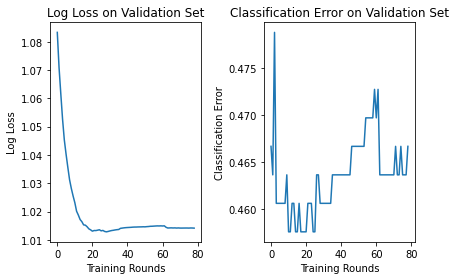

[18:50:27] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5878787878787879 0.9559858627391584 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=5,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              lambda=0, learning_rate=0.100000001, max_delta_step=1,
              max_depth=9, min_child_weight=9, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_class=3, num_parallel_tree=1, objective='multi:softprob',
              random_state=0, reg_alpha=0, reg_lambda=0, scale_pos_weight=None,
              subsample=0.95, tree_method='exact', use_label_encoder=False,
              validate_parameters=1, ...)
0.5575757575757576 

Pipeline(steps=[('scaler', StandardScaler()),
                ('softmax',
                 LogisticRegression(C=23.10129700083158,
                                    multi_class='multinomial', penalty='l1',
                                    solver='saga'))])

In [20]:
def model_select_sklearn(param_grid, mods, X_tr, y_tr, X_val, y_val):
    '''
    For each model class under consideration, the hyperparameters are tuned to 
    find the best model within the class. The best models of each class are refit
    on the training and validation sets and the test error is computed and the model
    with the highest test accuracy is chosen.
    
    Parameters:
    param_grid (dic): maps each parameter to a list of values to be tested
    mods (lst): list of multiclass classifiers
    Xtr (np.array): training data
    ytr (np.array): 1D array of training labels
    Xval (np.array): validation data
    yval (np.array): 1D array of validation labels
    
    Returns:
    best_mod (obj): the model with the highest test accuracy
    '''
    optimal_mods = []
    for name, mod in mods:
        fit_params = {}
        if name == 'xgb':
            fit_params = {'clf__early_stopping_rounds': 50,
                          'clf__eval_set': [(X_val.values, y_val.values)], 
                          'clf__eval_metric':['merror','mlogloss'],
                          'clf__verbose':False}
        val_scores, best_params = tune_hyperparams(
            mod, X_tr, y_tr, X_val, y_val, param_grids[name], fit_params)
        print(best_params)
        pipe = Pipeline(steps=[('scaler', preprocessing.StandardScaler()),
                               (name, mod.set_params(**best_params))])
        optimal_mods.append(pipe)
    plot_xgb(optimal_mods[0]['xgb'])
    top_logloss = np.inf
    for mod in optimal_mods:
        mod.fit(pd.concat((X_tr, X_val)), pd.concat((y_tr, y_val)))  #refit best models on training and validation sets
        test_acc = mod.score(X_tst, y_tst)
        test_logloss = log_loss(y_tst, mod.predict_proba(X_tst), labels=y_tst)
        print(test_acc, test_logloss, mod[1])
        if test_logloss <= top_logloss:
            best_mod = mod
            top_logloss = test_logloss
    
    return best_mod


def plot_xgb(mod):
    '''
    Plots the validation error at each epoch during the training of an xgboost model
    '''
    fig, ax = plt.subplots(1,2)
    eval_res = mod.evals_result()
    ax[0].plot(range(0, len(eval_res['validation_0']['mlogloss'])),
               eval_res['validation_0']['mlogloss'])
    ax[1].plot(range(0, len(eval_res['validation_0']['merror'])),
               eval_res['validation_0']['merror'])
    ax[0].set(xlabel = 'Training Rounds', ylabel = 'Log Loss')
    ax[1].set(xlabel='Training Rounds', ylabel='Classification Error')
    ax[0].set_title('Log Loss on Validation Set')
    ax[1].set_title('Classification Error on Validation Set')
    plt.tight_layout()
    plt.show()   


param_grids = {
                'xgb': 
                {'subsample': [.95],
                'colsample_bytree' : [1],
                'gamma': [5],
                'lambda': [0],
                'max_delta_step':[1],
                'eta': [.1], 'n_estimators': [500],
                'min_child_weight': [9], 'max_depth': [9],
                'objective': ['multi:softmax'],
                'num_class': [3]
               },
               'svc':
               {'C': [1], 'gamma': [1e-3], 'kernel':['rbf'], 'probability':[1]
               },
               'softmax': 
               {'C': np.geomspace(1e-3, 1e3, 100),
                'multi_class': ['multinomial'], 'penalty':['l1'],
               'solver': ['saga']} 
            }
mods = [('xgb', XGBClassifier(use_label_encoder=False)), 
        ('svc', SVC()), 
        ('softmax', LogisticRegression())
       ]

best_mod_sklearn = model_select_sklearn(param_grids, mods, X_tr, y_tr, X_val, y_val)
best_mod_sklearn


We also built a neural network using Pytorch but its performance ended up being only marginally better than the others so we still prefer the simpler multinomial logit model.

In [15]:
class Net(nn.Module):
    '''
    Defines a feedforward neural network where each layer is a compostion of an
    affine function with a nonlinear activation function that is applied elementwise.
    Dropout is applied to each layer except the output layer for regularization purposes.
    
    Attributes:
    linears: the linear layers
    output: the ouput layer
    activation: the activation function
    dropout: applies dropout
    '''
    def __init__(self, depth, width, activation, prob, num_classes):
        '''
        Constructor
        
        Parameters:
        depth (int): the number of hidden layers
        width (int): the number of units in each layer
        activation (torch.nn): the activation function (same one used for each layer)
        prob (float): the probability with which a neuron has its outgoing 
        connections killed in a dropout layer
        num_classes (int): the number of classes in our classification problem
            
        '''
        super(Net, self).__init__()
        self.linears = nn.ModuleList(
            [nn.Linear(width, width) if i!= 0 else nn.Linear(
            NUM_FEATS, width) for i in range(depth)])
        self.output = nn.Linear(width, num_classes)
        self.activation = activation
        #self.softmax = nn.Softmax()
        self.dropout = nn.Dropout(prob) 
    
    def forward(self, x):
        for l in self.linears:
            x = self.dropout(self.activation(l(x)))
        x = self.output(x)
        #x = self.softmax(x)
        
        return x

class MatchData(torch.utils.data.Dataset):
    def __init__(self, X, y):
        super(MatchData, self).__init__()
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.int64)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index,], self.y[index]


def normalize(X, mu, sd):
    '''
    Normalizes X by subtracting MU and dividing by SD
    '''
    return (X - mu) / sd


def compute_acc(labels, outputs):
    '''
    Converts raw ouput from network to a class prediction and computes accuracy
    relative to true labels
    '''
    preds = torch.argmax(outputs.data, 1)
    
    return (preds == labels).sum() / labels.size(0)


def train_nn(param_grid, criterion=None, X_tr=None, y_tr=None, X_val=None,
             y_val=None, checkpoint_dir=None):
    '''
    Trains neural net with a particular configuration of hyperparameters given by 
    the param grid. At each epoch the validation loss and accuracy is reported to ray tune.
    
    Parameters:
    param_grid (dic): maps hyperparameters to the particular value being tested
    Xtr (np.array): training data
    ytr (np.array): 1D array of training labels
    Xval (np.array): validation data
    yval (np.array): 1D array of validation labels
    '''
    net = Net(param_grid['depth'], param_grid['width'], param_grid['activation'],
              param_grid['prob'], NUM_CLASSES)
    #criterion = nn.CrossEntropyLoss()
    if param_grid['activation'] == 'nn.PReLU()':
        optimizer = optim.Adam([
            {'params': net.activation.parameters(), 'weight_decay':0},
            {'params': net.linears.parameters()},
            {'params': net.output.parameters()}
        ],
            lr=param_grid['lr'], weight_decay=param_grid['weight_decay'])
    else:
        optimizer = optim.Adam(net.parameters(), lr=param_grid['lr'],
                         weight_decay= param_grid['weight_decay'])
    if checkpoint_dir:
        mod_state, optim_state = torch.load(os.path.join(checkpoint_dir,
                                                         'checkpoint'))
        net.load_state_dict(mod_state)
        optimizer.load_state_dict(optim_state)
    trainset = MatchData(X_tr, y_tr)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=param_grid['batch'], 
                                              shuffle=True)
    
    for epoch in range(param_grid['epochs']):
        train_loop(trainloader, optimizer, criterion, net)
        with torch.no_grad():
            net.eval()
            val_labels = torch.tensor(y_val.values, dtype=torch.int64)
            val_outputs = net(torch.tensor(X_val.values, dtype=torch.float32))
            val_loss = criterion(val_outputs, val_labels).item()
            val_acc = compute_acc(val_labels, val_outputs)
            net.train()
        with tune.checkpoint_dir(epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, 'checkpoint')
            torch.save((net.state_dict(), optimizer.state_dict()), path)
            
        tune.report(loss=val_loss, acc=val_acc)

def train_loop(trainloader, optimizer, criterion, net):
    '''
    Loops over training data and updates the weights according the optimzation algorithm
    
    Parameters:
    trainloader: allows for iterating over the training set in batches
    optimizer: implements optimzation algorithm used, controls weight update
    criterion: defines the loss function that is being optimized
    net: the model 
    '''
    
    running_loss = 0
    for idx, batch in enumerate(trainloader):
        inputs, labels = batch
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #print(epoch, running_loss)
    mean_loss = running_loss / len(trainloader.dataset)
    #print(f"Train Loss: {mean_loss}")


        
def model_select_nn(param_grid, criterion, scheduler, num_trials, X_tr, y_tr,
                    X_val, y_val, X_tst, y_tst):
    '''
    Uses tune to draw samples of hyperparam configurations from the search space
    defined by the parameter grid and fits a model for each sample. The model with
    the lowest validation loss is chosen and is retrained on both the training and 
    validation set. The test accuracy is reported.
    
    Parameters:
    param_grid (dic): maps hyperparam to a distribution to draw samples from
    scheduler: algorithm used to implement early stopping and peturb hyperparams
    num_trials (int): the number of samples to draw
    Xtr (np.array): training data
    ytr (np.array): 1D array of training labels
    Xval (np.array): validation data
    yval (np.array): 1D array of validation labels
    Xtst (np.array): test data
    ytst (np.array): 1D array of test labels
    '''
    reporter = tune.JupyterNotebookReporter(
        metric_columns = ['loss', 'acc', 'training_iteration'], overwrite=1)
    res = tune.run(partial(
        train_nn, criterion=criterion, X_tr=X_tr, y_tr=y_tr, X_val=X_val, y_val=y_val),
             resources_per_trial={'cpu':4, 'gpu': 0},
             config=param_grid,
             scheduler=scheduler,
             progress_reporter=reporter,
             num_samples=num_trials)
    best_trial = res.get_best_trial('loss', 'min')
    print(best_trial.config)
    best_mod = Net(
        best_trial.config['depth'], best_trial.config['width'], best_trial.config['activation'],
                  best_trial.config['prob'], NUM_CLASSES)
    #best_checkpoint_dir = best_trial.checkpoint.value
    #mod_state, optim_state = torch.load(os.path.join(best_checkpoint_dir, 'checkpoint'))
    #best_mod.load_state_dict(mod_state)
    train_val_set = MatchData(pd.concat((X_tr, X_val)), pd.concat((y_tr, y_val)))
    train_val_loader = torch.utils.data.DataLoader(
        train_val_set, batch_size=best_trial.config['batch'],
                                                  shuffle=True)
    
    if best_trial.config['activation'] == 'nn.PReLU()':
        optimizer = optim.Adam([
            {'params': best_mod.activation.parameters(), 'weight_decay':0},
            {'params': best_mod.linears.parameters()},
            {'params': best_mod.output.parameters()}
        ],
            lr=best_trial.config['lr'], weight_decay=best_trial.config['weight_decay'])
    else:
        optimizer = optim.Adam(best_mod.parameters(), lr=best_trial.config['lr'],
                         weight_decay=best_trial.config['weight_decay'])
    
    for epoch in range(best_trial.config['epochs']):
        train_loop(train_val_loader, optimizer, criterion, best_mod)  
    best_mod.eval()
    with torch.no_grad():
        test_labels = torch.tensor(y_tst.values, dtype=torch.int64)
        test_outputs = best_mod(torch.tensor(X_tst.values, dtype=torch.float32))
        print(compute_acc(test_labels, test_outputs))
        print(criterion(test_outputs, test_labels).item())
    
    return best_mod


MU = np.mean(X_tr)
SD = np.sqrt(np.diag(np.cov(X_tr.T)))
X_tr = normalize(X_tr, MU, SD)
X_val = normalize(X_val, MU, SD)
X_tst = normalize(X_tst, MU, SD)

param_grid = {
    'depth': tune.randint(1, 5),
    'width': tune.randint(3, 15),
    'activation': tune.choice([nn.ReLU(), nn.PReLU()]),
    'epochs': tune.choice([10, 25, 40, 50, 75, 150]),
    'batch': tune.choice([2**i for i in range(1, 4)]),
    'lr': tune.loguniform(1e-4, 1e-1),
    #'momentum': tune.uniform(.9, .99),
    'prob': tune.uniform(.075,.25),
    'weight_decay':tune.uniform(1e-6, 1e-3)
}

'''
param_grid = {
    'depth': tune.randint(5,7),
    'width': tune.randint(8, 11),
    'activation': tune.choice([nn.ReLU(), nn.PReLU()]),
    'epochs': tune.choice([30, 40, 50, 75, 100 ,150]),
    'batch': tune.choice([2**i for i in range(1,3)]),
    'lr': tune.loguniform(1e-4, 1e-2),
    #'momentum': tune.uniform(.95, .99),
    'prob': tune.uniform(.05, .25),
    'weight_decay': tune.uniform(1e-5, 1e-3)
}
'''
scheduler = tune.schedulers.ASHAScheduler(metric = 'loss', mode='min')
num_trials = 50
loss = nn.CrossEntropyLoss()
best_mod_nn = model_select_nn(param_grid, loss, scheduler, num_trials, X_tr,
                              y_tr, X_val, y_val, X_tst, y_tst)


Trial name,status,loc,activation,batch,depth,epochs,lr,prob,weight_decay,width,loss,acc,training_iteration
DEFAULT_e31dd_00000,TERMINATED,,ReLU(),4,2,25,0.000338922,0.1614,0.000869629,13,1.00026,0.530303,25
DEFAULT_e31dd_00001,TERMINATED,,PReLU(num_parameters=1),8,1,10,0.000142961,0.243938,0.000268192,7,1.05853,0.439394,1
DEFAULT_e31dd_00002,TERMINATED,,PReLU(num_parameters=1),4,2,150,0.000286322,0.224242,0.000925807,4,1.10525,0.293939,1
DEFAULT_e31dd_00003,TERMINATED,,ReLU(),4,4,10,0.000149599,0.163603,0.000680447,9,1.07855,0.424242,1
DEFAULT_e31dd_00004,TERMINATED,,ReLU(),2,3,10,0.000208292,0.203616,0.000596882,11,1.07014,0.424242,1
DEFAULT_e31dd_00005,TERMINATED,,ReLU(),4,1,25,0.00143682,0.203124,0.000939835,13,0.998161,0.524242,16
DEFAULT_e31dd_00006,TERMINATED,,ReLU(),2,2,50,0.000726084,0.180434,0.000333947,14,1.00744,0.521212,4
DEFAULT_e31dd_00007,TERMINATED,,ReLU(),4,4,50,0.00110958,0.185578,5.27318e-05,7,1.04863,0.466667,1
DEFAULT_e31dd_00008,TERMINATED,,PReLU(num_parameters=1),2,3,150,0.00400313,0.107893,0.00098518,12,1.01768,0.481818,4
DEFAULT_e31dd_00009,TERMINATED,,PReLU(num_parameters=1),2,1,75,0.000454555,0.21837,0.00049765,12,1.03229,0.521212,1


2022-08-15 18:47:24,999	INFO tune.py:450 -- Total run time: 150.92 seconds (147.72 seconds for the tuning loop).


{'depth': 1, 'width': 13, 'activation': ReLU(), 'epochs': 25, 'batch': 4, 'lr': 0.0014368170918313472, 'prob': 0.20312413281679786, 'weight_decay': 0.000939835435266903}


/usr/local/lib/python3.8/dist-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


tensor(0.5606)
0.938477098941803


We gather all the information relevant to betting into one DataFrame: the true label, the predicted label, the odds for the 3 outcomes and the probability outputted by our model.

In [21]:
def create_betting_df(datasets, model, y_tst, indices):
    '''
    Creates DataFrame containing the true outcome, the predicted outcome,
    the probability associted with the predicted outcome and betting information
    for each match in the test set.
    
    Parameters:
    datasets (list): a list of DataFrames each containing the raw data for a single season
    model (sklearn obj): the best model
    y_tst (np.array): a 1D array of targets
    indices (list): list of indices into the original DataFrames that make up datasets
    
    Returns: 
    bets_df (DataFrame): DataFrame as described above
    '''
    odds_df = pd.DataFrame()
    for i, data in enumerate(datasets):
        odds_df = pd.concat((
            odds_df, data.iloc[:,BET_COL_IDX:BET_COL_IDX+3].iloc[indices[i]]))
    odds_df.reset_index(drop=True, inplace=True)
    ypred = model.predict(X_tst)
    probs = pd.Series(np.max(model.predict_proba(X_tst), axis=1), index=y_tst.index)
    ys = pd.DataFrame({'target': y_tst, 'predicted': ypred})
    ys_np = np.where(ys==2,'H', np.where(ys==0, 'A', 'D'))
    ys = pd.DataFrame(ys_np, columns=ys.columns, index=ys.index)
    bets_df = ys.join(odds_df)
    bets_df['probability'] = probs
    return bets_df

bet_df = create_betting_df(datasets, best_mod_sklearn, y_tst, indices)
bet_df.loc[bet_df['target'] == bet_df['predicted']]

,target,predicted,B365H,B365D,B365A,probability
1650,A,A,5.00,4.0,1.75,0.466520
1652,A,A,23.00,8.0,1.16,0.755019
1655,H,H,1.61,4.0,6.50,0.658482
1656,H,H,1.20,7.5,17.00,0.734444
1658,H,H,1.44,5.0,7.50,0.551273
...,...,...,...,...,...,...
1970,A,A,19.00,8.5,1.16,0.707251
1971,A,A,3.25,3.8,2.20,0.473823
1972,H,H,1.90,4.2,3.80,0.393682
1973,A,A,2.50,3.6,2.90,0.380261


We consider a few betting strategies, all of which are quite straightforward. The most viable one is the conservative strategy which consists in placing a bet proportional to the probability outputted by the model, only if the probability is greater than some threshold; so we only placed bets if we met some confidence level. We seek the largest return subject to a minimum number of bets placed, as the returns on strategies that place a low number of bets are subject to high variance.    

In [22]:
def simple_strat(row, factor=1, prop_to_prob=False):
    '''
    Defines a simple betting strategy where the stake is equal to a constant times
    the probability of the class outputted by the model, or it is simply the constant.
    
    Parameters: 
    row (Series): contains prediction, true result and betting information
    factor (int): the stake
    prop_to_prob (bool): whether the stake should be proportional to the probability
    
    Returns: -stake if bet is lost, and the stake multiplied by the odds if won   
    '''
    
    if prop_to_prob:
        stake = factor * row[5]
    else:
        stake = factor
    if row[0] != row[1]:
        return -stake 
    if row[0] == 'H':
        return  stake * (row[2])
    elif row[0] == 'A':
        return  stake * (row[4])
    else:
        return stake * (row[3])

def decimal_to_prob(decimal):
    '''
    Obtains the implied probability given decimal odds.
    '''
    return 1/decimal
    
def value_strat(row, factor, prop_to_prob):
    '''
    Defines a betting strategy that identifies good value bets by comparing the
    model's confidence of the result to the bookmakers'confidence.
    
    Parameters: 
    row (Series): contains prediction, true result and betting information
    factor (int): the stake
    prop_to_prob (bool): whether the stake should be proportional to the probability
    
    Returns: -stake if bet is lost, and the stake multiplied by the odds if won 
    
    '''
    if row[5] >= decimal_to_prob(min(row[2:5])):
        return simple_strat(row, factor, prop_to_prob)
    else:
        return 0

def conservative_strat(row, factor, prop_to_prob, threshold):
    '''
    Defines a conservative betting strategy that only places a bet only if the
    model is confident in its prediction. In other words, we place a bet if the
    probability is greater than some threshold.
    
    Parameters: 
    row (Series): contains prediction, true result and betting information
    factor (int): the stake
    prop_to_prob (bool): whether the stake should be proportional to the probability
    threshold (float): controls the conservativeness of the strategy, should lie in [0,1] 
    
    Returns: -stake if bet is lost, and the stake multiplied by the odds if won 
    
    '''
    if row[5] >= threshold:
        return simple_strat(row, factor, prop_to_prob)
    else: 
        return 0


In [26]:
def evaluate_strategy(strat, bets_df, datasets, args=None):
    '''
    Evaluates the performance of a betting salary by noting the number of bets placed, 
    the total winnings (not including expenditure), the most profitable bet and
    the percent return.
    
    Parameters:
    strat (function): the betting strategy
    bets_df (DataFrame): DataFrame containing the true outcome, the predicted
    outcome, the probability associted with the predicted outcome and betting information
    for each match in the test set
    datasets (list): list of DataFrames, one for each season. Used to get the
    identity of the teams competing in the match that was the most profitable bet
    args (tuple): positional arguements to be passed to strat
    
    Returns: the percent return and number of bets placed                    
    '''
    print(strat.__name__)
    bet_df['winnings'] = bet_df.apply(strat, axis=1, args=args)
    num_bets = bet_df.loc[bet_df['winnings'] != 0].shape[0]
    print("Number of bets placed: {}".format(num_bets))
    running_winnings = bet_df['winnings'].sort_index().expanding().sum()
    print("Total winnings: {}".format(running_winnings.iloc[-1]))
    #print("Losing Money:")
    #print(running_winnings.loc[running_winnings < 0])
    #print(bet_df.loc[bet_df['winnings']!=0])
    print(bet_df.loc[bet_df.index == bet_df['winnings'].idxmax()])
    print(datasets[bet_df['winnings'].idxmax() // len(y_tst)].iloc[
        MIN_PERIODS*10 + bet_df['winnings'].idxmax() % len(y_tst),:6])
    if strat.__name__ == 'conservative_strat' and args[1]:
        expenditure = args[0] * bet_df.loc[
        bet_df['probability'] >= args[2]]['probability'].sum()
        print("Expenditure: {}".format(expenditure))
        percent_return = 100 * (running_winnings.iloc[-1] - expenditure) / expenditure
        print('{}% return'.format(percent_return))
    
    return percent_return, num_bets

thresh = .725
num_bets = len(y_tst)
percent_return = 1
while (num_bets >= 30 and percent_return >= 0):
    percent_return, num_bets = evaluate_strategy(
        conservative_strat, bet_df, datasets, args=(25, True, thresh))
    thresh += .025
    
#thresh


conservative_strat
Number of bets placed: 34
Total winnings: 669.5649263995439
     target predicted  B365H  B365D  B365A  probability   winnings
1703      H         H   1.61    4.0    6.5     0.741815  29.858067
Div                             E0
Date                    03/11/2018
HomeTeam                Everton FC
AwayTeam    Brighton & Hove Albion
FTHG                             3
FTAG                             1
Name: 103, dtype: object
Expenditure: 657.1614280206487
1.8874355447571147% return
conservative_strat
Number of bets placed: 23
Total winnings: 488.386334518552
     target predicted  B365H  B365D  B365A  probability   winnings
1946      H         H   1.28    6.0   13.0     0.813001  26.016022
Div                             E0
Date                    23/04/2019
HomeTeam         Tottenham Hotspur
AwayTeam    Brighton & Hove Albion
FTHG                             1
FTAG                             0
Name: 346, dtype: object
Expenditure: 454.547085997157
7.444607954566594